# CNN Model Training for Leaf Disease Classification

Ce notebook permet d'entraîner un modèle CNN profond pour classifier les maladies des feuilles avec plus de 90% de précision.

## 1. Configuration de l'Environnement

In [18]:
import os
import zipfile
import cv2
import numpy as np
import matplotlib.pyplot as plt
import time

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D
from tensorflow.keras.layers import Flatten, Dropout, Input, BatchNormalization
from tensorflow.keras.utils import to_categorical, Sequence
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

print("Imports terminés")
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

Imports terminés


## 2. Configuration des Paramètres

In [ ]:
# Paramètres principaux
DATA_DIR = "../Apple"
IMAGE_SIZE = (128, 128)  # Taille des images d'entrée
BATCH_SIZE = 32
EPOCHS = 30
SPLIT_RATIO = 0.8  # 80% train, 20% validation
OUTPUT_MODEL = "../output_model.zip"  # Fichier de sortie

print(f"Dataset: {DATA_DIR}")
print(f"Taille d'image: {IMAGE_SIZE}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Epochs: {EPOCHS}")

Dataset: ../Apple
Taille d'image: (128, 128)
Batch size: 32
Epochs: 30


## 3. Chargement et Analyse du Dataset

In [ ]:
def load_dataset(data_dir):
    """Charge les chemins et labels du dataset."""
    image_paths = []
    labels = []

    print("Chargement du dataset...")
    start_time = time.time()

    for subdir in os.listdir(data_dir):
        path = os.path.join(data_dir, subdir)
        if os.path.isdir(path):
            try:
                label = subdir.split('_', 1)[1]
                files = [f for f in os.listdir(path)
                         if f.lower().endswith(('.jpg'))]

                for file in files:
                    image_path = os.path.join(path, file)
                    image_paths.append(image_path)
                    labels.append(label)

                print(f"  {subdir}: {len(files)} images")
            except ValueError:
                print(f"  Ignoré: {subdir}")

    load_time = time.time() - start_time
    print(f"\n✓ Dataset chargé en {load_time:.2f}s")
    print(f"Total: {len(image_paths)} images")
    return image_paths, labels

image_paths, labels = load_dataset(DATA_DIR)

Chargement du dataset...
  Apple_Black_rot: 1640 images
  Apple_rust: 1640 images
  Apple_scab: 1640 images
  Apple_healthy: 1640 images

✓ Dataset chargé en 0.00s
Total: 6560 images


## 4. Séparation Train/Validation Stratifiée

In [ ]:
def split_dataset(image_paths, labels, split_ratio=0.8):
    """Sépare le dataset de manière stratifiée."""
    train_paths, train_labels = [], []
    val_paths, val_labels = [], []

    classes = set(labels)
    print(f"\nClasses trouvées: {len(classes)}")
    print(f"Classes: {sorted(classes)}\n")

    for cls in classes:
        cls_indexes = [i for i, label in enumerate(labels) if label == cls]
        cls_image_paths = [image_paths[i] for i in cls_indexes]
        cls_labels = [labels[i] for i in cls_indexes]

        split_index = int(len(cls_indexes) * split_ratio)

        train_paths.extend(cls_image_paths[:split_index])
        train_labels.extend(cls_labels[:split_index])
        val_paths.extend(cls_image_paths[split_index:])
        val_labels.extend(cls_labels[split_index:])

        print(f"  {cls}: {split_index} train,"
              f"{len(cls_indexes)-split_index} val")

    return train_paths, train_labels, val_paths, val_labels

train_paths, train_labels, val_paths, val_labels = split_dataset(
    image_paths, labels, SPLIT_RATIO
)

print(f"\n Training: {len(train_paths)} images")
print(f" Validation: {len(val_paths)} images")


Classes trouvées: 4
Classes: ['Black_rot', 'healthy', 'rust', 'scab']

  Black_rot: 1312 train, 328 val
  scab: 1312 train, 328 val
  healthy: 1312 train, 328 val
  rust: 1312 train, 328 val

 Training: 5248 images
 Validation: 1312 images


## 5. Data Generator Optimisé

In [ ]:
class OptimizedDataGenerator(Sequence):
    """Générateur de données optimisé pour la vitesse et la précision."""

    def __init__(self, image_paths, labels, batch_size=32,
                 image_size=(128, 128), n_classes=10, shuffle=True,
                 label_encoder=None):
        self.image_paths = image_paths
        self.labels = labels
        self.batch_size = batch_size
        self.image_size = image_size
        self.n_classes = n_classes
        self.shuffle = shuffle

        if label_encoder is not None:
            self.labels_encoder = label_encoder
        else:
            self.labels_encoder = LabelEncoder()
            self.labels_encoder.fit(labels)

        super().__init__()
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.image_paths) / self.batch_size))

    def __getitem__(self, index):
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        image_paths_temp = [self.image_paths[k] for k in indexes]
        labels_temp = [self.labels[k] for k in indexes]
        X, y = self.__data_generation(image_paths_temp, labels_temp)
        return X, y

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.image_paths))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __data_generation(self, image_paths_temp, labels_temp):
        X = np.empty((self.batch_size, *self.image_size, 3), dtype=np.float32)
        y = np.empty((self.batch_size), dtype=int)

        for i, (image_path, label) in enumerate(zip(image_paths_temp,
                                                    labels_temp)):
            try:
                image = cv2.imread(image_path)
                if image is None:
                    image = np.zeros((*self.image_size, 3), dtype=np.uint8)
                else:
                    image = cv2.resize(image, self.image_size,
                                       interpolation=cv2.INTER_AREA)

                X[i,] = image.astype(np.float32) / 255.0
                y[i] = self.labels_encoder.transform([label])[0]
            except Exception as e:
                print(f"Erreur: {e}")
                X[i,] = np.zeros((*self.image_size, 3), dtype=np.float32)
                y[i] = 0

        return X, to_categorical(y, num_classes=self.n_classes)

print("Data Generator défini")

Data Generator défini


## 6. Création des Générateurs

In [ ]:
# Créer l'encodeur partagé
all_labels = train_labels + val_labels
n_classes = len(set(all_labels))

shared_label_encoder = LabelEncoder()
shared_label_encoder.fit(all_labels)

print(f"Nombre de classes: {n_classes}")
print(f"Mapping des labels: {dict(zip(shared_label_encoder.classes_,
      range(n_classes)))}")

# Créer les générateurs
train_generator = OptimizedDataGenerator(
    train_paths,
    train_labels,
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE,
    n_classes=n_classes,
    label_encoder=shared_label_encoder
)

val_generator = OptimizedDataGenerator(
    val_paths,
    val_labels,
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE,
    n_classes=n_classes,
    shuffle=False,
    label_encoder=shared_label_encoder
)

print(f"\nGénérateur train: {len(train_generator)} batches")
print(f"Générateur val: {len(val_generator)} batches")

Nombre de classes: 4
Mapping des labels: {np.str_('Black_rot'): 0, np.str_('healthy'): 1, np.str_('rust'): 2, np.str_('scab'): 3}

Générateur train: 164 batches
Générateur val: 41 batches


## 7. Architecture du Modèle CNN

Modèle CNN profond avec 4 blocs convolutionnels pour atteindre >90% de précision.

In [10]:
def build_optimized_model(input_shape, num_classes):
    """
    Modèle CNN optimisé avec architecture profonde.
    """
    model = Sequential([
        Input(shape=input_shape),

        # Bloc 1 - Extraction de features basiques
        Conv2D(32, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(32, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),

        # Bloc 2 - Features complexes
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),

        # Bloc 3 - Features avancées
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),

        # Bloc 4 - Features de haut niveau
        Conv2D(256, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(256, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.3),

        # Couches de classification
        Flatten(),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.4),
        Dense(num_classes, activation='softmax')
    ])

    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

input_shape = IMAGE_SIZE + (3,)
model = build_optimized_model(input_shape, n_classes)

print("\n=== ARCHITECTURE DU MODÈLE ===")
model.summary()


=== ARCHITECTURE DU MODÈLE ===


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 9,700,644 (37.01 MB)

 Trainable params: 9,697,188 (36.99 MB)

 Non-trainable params: 3,456 (13.50 KB)

## 8. Callbacks d'Entraînement

In [11]:
# Callbacks pour optimiser l'entraînement
callbacks = [
    EarlyStopping(
        monitor='val_accuracy',
        patience=8,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=4,
        min_lr=0.00001,
        verbose=1
    )
]

print("✓ Callbacks configurés")
print("  - EarlyStopping: patience=8")
print("  - ReduceLROnPlateau: factor=0.5, patience=4")

✓ Callbacks configurés
  - EarlyStopping: patience=8
  - ReduceLROnPlateau: factor=0.5, patience=4


## 9. Entraînement du Modèle

In [12]:
print("\n=== DÉBUT DE L'ENTRAÎNEMENT ===")
start_time = time.time()

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1
)

training_time = time.time() - start_time
print(f"\nEntraînement terminé en {training_time:.2f}s"
      f"({training_time/60:.1f} min)")


=== DÉBUT DE L'ENTRAÎNEMENT ===
Epoch 1/30
164/164 ━━━━━━━━━━━━━━━━━━━━ 190s 1s/step - accuracy: 0.8468 - loss: 0.4526 - val_accuracy: 0.2500 - val_loss: 22.6685 - learning_rate: 0.0010
Epoch 2/30
164/164 ━━━━━━━━━━━━━━━━━━━━ 208s 1s/step - accuracy: 0.9167 - loss: 0.2481 - val_accuracy: 0.2500 - val_loss: 14.8339 - learning_rate: 0.0010
Epoch 3/30
164/164 ━━━━━━━━━━━━━━━━━━━━ 194s 1s/step - accuracy: 0.9392 - loss: 0.1772 - val_accuracy: 0.4642 - val_loss: 4.9557 - learning_rate: 0.0010
Epoch 4/30
164/164 ━━━━━━━━━━━━━━━━━━━━ 222s 1s/step - accuracy: 0.9497 - loss: 0.1388 - val_accuracy: 0.8552 - val_loss: 0.6598 - learning_rate: 0.0010
Epoch 5/30
164/164 ━━━━━━━━━━━━━━━━━━━━ 221s 1s/step - accuracy: 0.9457 - loss: 0.1567 - val_accuracy: 0.9360 - val_loss: 0.1843 - learning_rate: 0.0010
Epoch 6/30
164/164 ━━━━━━━━━━━━━━━━━━━━ 202s 1s/step - accuracy: 0.9615 - loss: 0.1175 - val_accuracy: 0.9527 - val_loss: 0.1472 - learning_rate: 0.0010
Epoch 7/30
164/164 ━━━━━━━━━━━━━━━━━━━━ 201s 1s

## 10. Évaluation Finale

In [13]:
print("\n=== ÉVALUATION FINALE ===")
loss, accuracy = model.evaluate(val_generator, verbose=0)
print(f"Précision finale: {accuracy * 100:.2f}%")
print(f"Perte finale: {loss:.4f}")


=== ÉVALUATION FINALE ===
Précision finale: 99.85%
Perte finale: 0.0055


## 11. Visualisation de l'Historique d'Entraînement

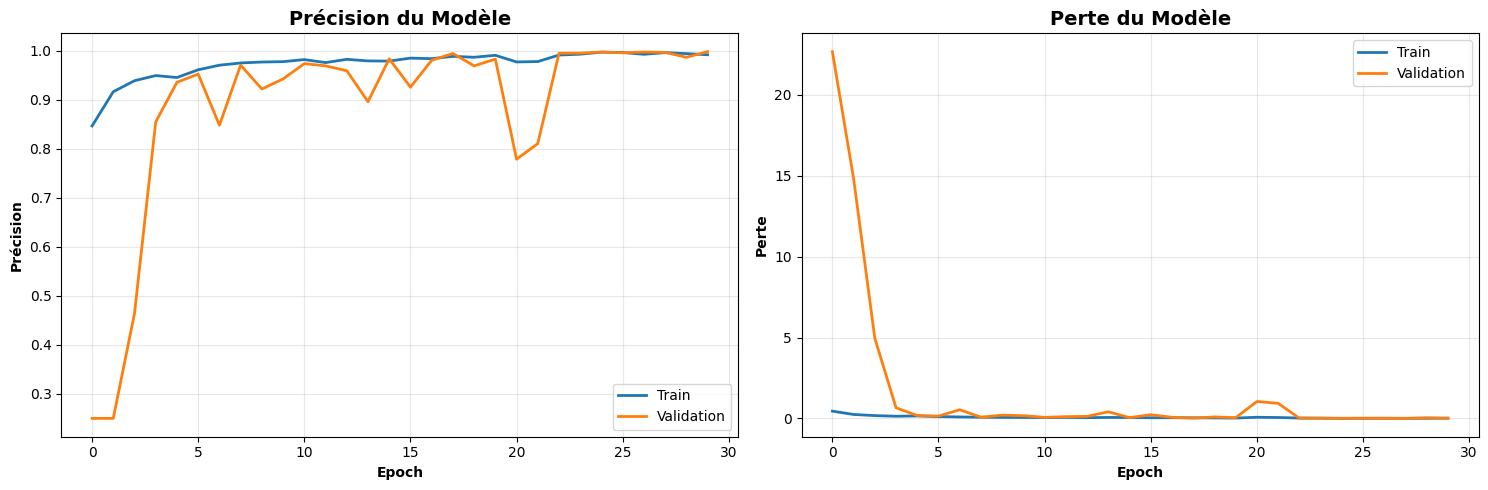


=== STATISTIQUES D'ENTRAÎNEMENT ===
Meilleure précision train:99.75%
Meilleure précision val:99.85%
Perte finale train: 0.0231
Perte finale val: 0.0055


In [14]:
def plot_training_history(history):
    """
    Visualise l'évolution de la précision et de la perte.
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Précision
    ax1.plot(history.history['accuracy'], label='Train', linewidth=2)
    ax1.plot(history.history['val_accuracy'], label='Validation', linewidth=2)
    ax1.set_title('Précision du Modèle', fontweight='bold', fontsize=14)
    ax1.set_xlabel('Epoch', fontweight='bold')
    ax1.set_ylabel('Précision', fontweight='bold')
    ax1.legend()
    ax1.grid(alpha=0.3)

    # Perte
    ax2.plot(history.history['loss'], label='Train', linewidth=2)
    ax2.plot(history.history['val_loss'], label='Validation', linewidth=2)
    ax2.set_title('Perte du Modèle', fontweight='bold', fontsize=14)
    ax2.set_xlabel('Epoch', fontweight='bold')
    ax2.set_ylabel('Perte', fontweight='bold')
    ax2.legend()
    ax2.grid(alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Statistiques
    print("\n=== STATISTIQUES D'ENTRAÎNEMENT ===")
    print("Meilleure précision train:"
          f"{max(history.history['accuracy'])*100:.2f}%")
    print("Meilleure précision val:"
          f"{max(history.history['val_accuracy'])*100:.2f}%")
    print(f"Perte finale train: {history.history['loss'][-1]:.4f}")
    print(f"Perte finale val: {history.history['val_loss'][-1]:.4f}")

plot_training_history(history)

## 12. Sauvegarde du Modèle

In [15]:
def save_model_and_samples(model, data_dir, output_zip):
    """
    Sauvegarde le modèle et des échantillons d'images dans un fichier zip.
    """
    print(f"\nSauvegarde du modèle dans {output_zip}...")
    start_time = time.time()

    with zipfile.ZipFile(output_zip, 'w', zipfile.ZIP_DEFLATED) as zipf:
        # Sauvegarder le modèle
        model_file = 'model.h5'
        model.save(model_file)
        zipf.write(model_file)
        os.remove(model_file)

        # Sauvegarder des échantillons (10 par classe)
        total_images = 0
        for subdir in os.listdir(data_dir):
            path = os.path.join(data_dir, subdir)
            if os.path.isdir(path):
                files = [f for f in os.listdir(path)
                         if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
                for file in files[:10]:
                    image_path = os.path.join(path, file)
                    zipf.write(image_path, f"samples/{subdir}/{file}")
                    total_images += 1

        save_time = time.time() - start_time
        print(f"Sauvegarde terminée en {save_time:.2f}s")
        print("  - Modèle: model.h5")
        print(f"  - Échantillons: {total_images} images")

save_model_and_samples(model, DATA_DIR, OUTPUT_MODEL)
print(f"\nModèle sauvegardé: {OUTPUT_MODEL}")


Sauvegarde du modèle dans output_model.zip...
Sauvegarde terminée en 2.81s
  - Modèle: model.h5
  - Échantillons: 40 images

Modèle sauvegardé: output_model.zip


## 13. Matrice de Confusion


Génération de la matrice de confusion...


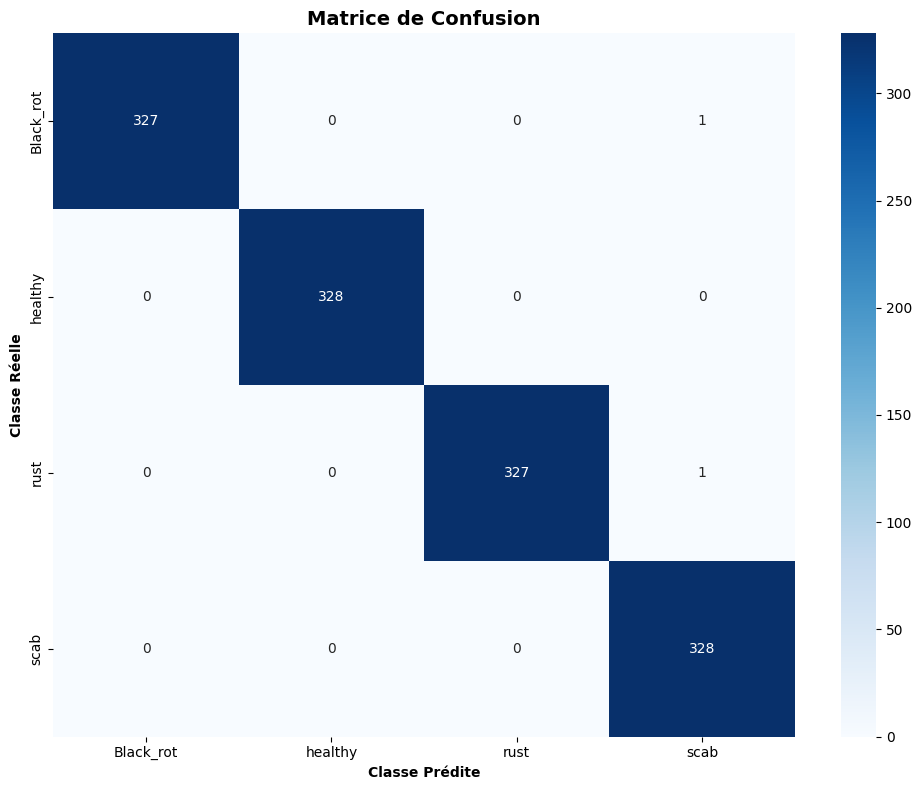


=== RAPPORT DE CLASSIFICATION ===
              precision    recall  f1-score   support

   Black_rot       1.00      1.00      1.00       328
     healthy       1.00      1.00      1.00       328
        rust       1.00      1.00      1.00       328
        scab       0.99      1.00      1.00       328

    accuracy                           1.00      1312
   macro avg       1.00      1.00      1.00      1312
weighted avg       1.00      1.00      1.00      1312



In [19]:
def plot_confusion_matrix(model, val_generator, class_names):
    """
    Affiche la matrice de confusion.
    """
    print("\nGénération de la matrice de confusion...")

    # Prédictions
    y_pred = model.predict(val_generator, verbose=0)
    y_pred_classes = np.argmax(y_pred, axis=1)

    # Labels réels
    y_true = []
    for i in range(len(val_generator)):
        _, y_batch = val_generator[i]
        y_true.extend(np.argmax(y_batch, axis=1))
    y_true = np.array(y_true[:len(y_pred_classes)])

    # Matrice de confusion
    cm = confusion_matrix(y_true, y_pred_classes)

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names)
    plt.title('Matrice de Confusion', fontweight='bold', fontsize=14)
    plt.ylabel('Classe Réelle', fontweight='bold')
    plt.xlabel('Classe Prédite', fontweight='bold')
    plt.tight_layout()
    plt.show()

    # Rapport de classification
    print("\n=== RAPPORT DE CLASSIFICATION ===")
    print(classification_report(y_true, y_pred_classes,
                                target_names=class_names))

class_names = shared_label_encoder.classes_
plot_confusion_matrix(model, val_generator, class_names)